# In this notebook, we only focus on cleaning the eviction dataset from:

https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4/data_preview

The explanations of the data can be found here: https://data.cityofnewyork.us/City-Government/Evictions/6z8x-wfk4/about_data

- Overall, the originally downloaded dataset ranges from 2017 - 2025.02.22, but in this notebook, we will ignore the 2025 data, and only focus on 2017 - 2024. We went from 104,457 records and 20 columns, to 80435 records 20 columns. We create a new primary key, removed 3 irrelevant ones, and added 2 for visuals and summaries.
- We only focused on residential records and dropped commercial records (the ratio is roughly 9:1)
- We cleaned "court_index_number" and "docket_number" to remove the duplicates. We then combined them and created a primary key as a new column.
- We made the column names easier to read.
- We dropped rows that have nans in critical columns.
- Finally, we included bar charts and statistical summaries to observe the spatial and temporal trends, and will include them later in the formal analysis.

We saved the cleaned dataset (with as many columns as possible) to google drive (not every column will be utilized, but for completeness, we saved everything). In the next notebooks, we will do data exploration, merge, and test out hypotheses regarding complaints and evictions, clusterings in NYC, relationships with BBL and SVI.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import folium
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/X999/Evictions.csv'

Mounted at /content/drive


In [3]:
evictions_df_raw = pd.read_csv(file_path)

In [4]:
evictions_df = evictions_df_raw.copy()

In [5]:
evictions_df.head(1)

,Court Index Number,Docket Number,Eviction Address,Eviction Apartment Number,Executed Date,Marshal First Name,Marshal Last Name,Residential/Commercial,BOROUGH,Eviction Postcode,Ejectment,Eviction/Legal Possession,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,22379/19,354582,2915 LA SALLE AVENUE,3R,08/14/2019,Thomas,Bia,Residential,BRONX,10461,Not an Ejectment,Possession,40.839044,-73.830768,10.0,13.0,184.0,2073762.0,2.053580e+09,Schuylerville-Throgs Neck-Edgewater Park


In [6]:
evictions_df.shape

(104457, 20)

# **Step 1: check nans**

In [7]:
nan_counts = evictions_df.isna().sum()

In [8]:
columns_with_nans = nan_counts[nan_counts > 0]
columns_with_nans

,0
Eviction Apartment Number,15743
Latitude,9408
Longitude,9408
Community Board,9408
Council District,9408
Census Tract,9408
BIN,9675
BBL,9675
NTA,9408


In [9]:
nan_summary = pd.DataFrame({
    'column name': columns_with_nans.index,
    'nan count': columns_with_nans.values,
    'percentage': (columns_with_nans.values / len(evictions_df) * 100).round(2)
}).sort_values(by='nan count', ascending=False)

## **A lot of nan values with critical information. We have no choice but to drop them eventually, but we can do it after some cleaning to see if any of these make sense.**

In [10]:
nan_summary

,column name,nan count,percentage
0,Eviction Apartment Number,15743,15.07
7,BBL,9675,9.26
6,BIN,9675,9.26
1,Latitude,9408,9.01
2,Longitude,9408,9.01
4,Council District,9408,9.01
3,Community Board,9408,9.01
5,Census Tract,9408,9.01
8,NTA,9408,9.01


In [11]:
df_with_nans = evictions_df[columns_with_nans.index]
df_with_nans.head()

,Eviction Apartment Number,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,3R,40.839044,-73.830768,10.0,13.0,184.0,2073762.0,2.053580e+09,Schuylerville-Throgs Neck-Edgewater Park
1,3H,40.720081,-73.979203,3.0,2.0,2202.0,1088845.0,1.003720e+09,Lower East Side
2,1,40.869928,-73.864326,12.0,15.0,338.0,2055595.0,2.045700e+09,Bronxdale
3,4D,40.762694,-73.985799,5.0,3.0,131.0,1024813.0,1.010220e+09,Midtown-Midtown South
4,C5,40.857435,-73.902345,5.0,14.0,239.0,2013995.0,2.031820e+09,Fordham South


In [12]:
evictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104457 entries, 0 to 104456
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Court Index Number         104457 non-null  object 
 1   Docket Number              104457 non-null  int64  
 2   Eviction Address           104457 non-null  object 
 3   Eviction Apartment Number  88714 non-null   object 
 4   Executed Date              104457 non-null  object 
 5   Marshal First Name         104457 non-null  object 
 6   Marshal Last Name          104457 non-null  object 
 7   Residential/Commercial     104457 non-null  object 
 8   BOROUGH                    104457 non-null  object 
 9   Eviction Postcode          104457 non-null  int64  
 10  Ejectment                  104457 non-null  object 
 11  Eviction/Legal Possession  104457 non-null  object 
 12  Latitude                   95049 non-null   float64
 13  Longitude                  95

In [13]:
evictions_df.head()

,Court Index Number,Docket Number,Eviction Address,Eviction Apartment Number,Executed Date,Marshal First Name,Marshal Last Name,Residential/Commercial,BOROUGH,Eviction Postcode,Ejectment,Eviction/Legal Possession,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,22379/19,354582,2915 LA SALLE AVENUE,3R,08/14/2019,Thomas,Bia,Residential,BRONX,10461,Not an Ejectment,Possession,40.839044,-73.830768,10.0,13.0,184.0,2073762.0,2.053580e+09,Schuylerville-Throgs Neck-Edgewater Park
1,55120/17,22819,310 EAST 2ND STREET,3H,01/25/2018,Gary,Rose,Residential,MANHATTAN,10009,Not an Ejectment,Possession,40.720081,-73.979203,3.0,2.0,2202.0,1088845.0,1.003720e+09,Lower East Side
2,308641/22,366619,3003 WALLACE AVENUE,1,11/13/2023,Thomas,Bia,Residential,BRONX,10467,Not an Ejectment,Possession,40.869928,-73.864326,12.0,15.0,338.0,2055595.0,2.045700e+09,Bronxdale
3,317985/23,43913,840 8TH AVENUE,4D,02/05/2025,Edward,Guida,Residential,MANHATTAN,10019,Not an Ejectment,Possession,40.762694,-73.985799,5.0,3.0,131.0,1024813.0,1.010220e+09,Midtown-Midtown South
4,343999/23,137070,2263 MORRIS AVENUE,C5,09/12/2024,Justin,Grossman,Residential,BRONX,10453,Not an Ejectment,Possession,40.857435,-73.902345,5.0,14.0,239.0,2013995.0,2.031820e+09,Fordham South


In [14]:
evictions_df.columns

Index(['Court Index Number', 'Docket Number ', 'Eviction Address',
       'Eviction Apartment Number', 'Executed Date', 'Marshal First Name',
       'Marshal Last Name', 'Residential/Commercial', 'BOROUGH',
       'Eviction Postcode', 'Ejectment', 'Eviction/Legal Possession',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [15]:
evictions_df['Residential/Commercial'].value_counts()

,count
Residential/Commercial,
Residential,94907
Commercial,9550


In [16]:
evictions_df[evictions_df['Residential/Commercial'] == "Residential"].shape[0]/evictions_df.shape[0],\
evictions_df[evictions_df['Residential/Commercial'] == "Commercial"].shape[0]/evictions_df.shape[0]

(0.9085748202609686, 0.09142517973903137)

In [17]:
# percentage
evictions_df['Residential/Commercial'].value_counts(normalize=True) * 100

,proportion
Residential/Commercial,
Residential,90.857482
Commercial,9.142518


# **90.86% of the evictions during 2017 to 2024 are residential ones**

In [18]:
evictions_df["Marshal Last Name"].head()
# will drop this coloumn

,Marshal Last Name
0,Bia
1,Rose
2,Bia
3,Guida
4,Grossman


# **Step 2: clean the column names and drop commercial evictions**

In [19]:
# convert all the column names into lower case, strip the final space, and change the spaces betwen words to "_"
def clean_column_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    return df

In [20]:
evictions_df.columns

Index(['Court Index Number', 'Docket Number ', 'Eviction Address',
       'Eviction Apartment Number', 'Executed Date', 'Marshal First Name',
       'Marshal Last Name', 'Residential/Commercial', 'BOROUGH',
       'Eviction Postcode', 'Ejectment', 'Eviction/Legal Possession',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [21]:
# evictions_df['bbl'] = evictions_df['bbl'].astype(int)
# evictions_df['bin'] = evictions_df['bin'].astype(int)

In [22]:
evictions_df = clean_column_names(evictions_df)
evictions_df.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'marshal_first_name',
       'marshal_last_name', 'residential/commercial', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')

In [23]:
evictions_df.shape
# original dataset's volumn:
# 104467, 20
# only residential ones are left in the df now

(104457, 20)

In [24]:
evictions_df["residential/commercial"].unique(), \
evictions_df.shape

(array(['Residential', 'Commercial'], dtype=object), (104457, 20))

In [25]:
evictions_df = evictions_df[evictions_df["residential/commercial"] != "Commercial"]

In [26]:
evictions_df.shape, 6057/94907

((94907, 20), 0.06382037152159482)

In [27]:
evictions_df.isna().sum()

,0
court_index_number,0
docket_number,0
eviction_address,0
eviction_apartment_number,10896
executed_date,0
marshal_first_name,0
marshal_last_name,0
residential/commercial,0
borough,0
eviction_postcode,0


## **All these columns matter, but they have a lot of nans. Let's see if we can fillna with some meaningful values to avoid dropping all of them (about 6.38% of the whole dataset)**

In [28]:
type(evictions_df["eviction_apartment_number"][0]), type(evictions_df["community_board"][0]), \
type(evictions_df["council_district"][0]), type(evictions_df["census_tract"][0]), \
type(evictions_df["bin"][0]), type(evictions_df["bbl"][0])

(str,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64)

## **Though "eviction apartment number" column has NaN, we will still keep these string values there, because they might be interesting to look at for certain case studies later.**

In [29]:
evictions_df['eviction_apartment_number'].fillna("unknown", inplace=True)

In [30]:
evictions_df.shape

(94907, 20)

In [31]:
evictions_df.dropna(inplace=True)

In [32]:
evictions_df.shape, 94907 - 88471, (94907 - 88471)/94907 # removed 6.78% of rows that contain nan values in critical columns

((88471, 20), 6436, 0.06781375451758037)

In [33]:
evictions_df["residential/commercial"].unique()

array(['Residential'], dtype=object)

In [34]:
evictions_df.shape

(88471, 20)

In [35]:
len(evictions_df.court_index_number.unique()), \
len(evictions_df.docket_number.unique())
# court_index_number is supposed to be the primary key, but they also have duplicates

(82473, 75088)

In [36]:
evictions_df.drop_duplicates(inplace=True)

In [37]:
len(evictions_df.court_index_number.unique()), \
len(evictions_df.docket_number.unique())
# no duplicates found

(82473, 75088)

In [38]:
court_index_counts = evictions_df['court_index_number'].value_counts()
duplicate_court_indices = court_index_counts[court_index_counts > 1]
duplicate_court_indices

,count
court_index_number,
7997/18,6
52516/19,5
308641/22,5
60936/17,5
67381/17,5
...,...
66064/18,2
61024/18,2
37899/17,2


In [39]:
# some sample duplicated court_index_numbers but they contain different information:
duplicate_court_indices.index[0], duplicate_court_indices.index[1], duplicate_court_indices.index[2]

('7997/18', '52516/19', '308641/22')

In [40]:
example_rows = evictions_df[evictions_df['court_index_number'] == '7997/18']
example_rows

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,residential/commercial,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
1055,7997/18,24271,2840 BRUNER AVENUE,unknown,08/08/2019,Edward,Guida,Residential,BRONX,10469,Not an Ejectment,Possession,40.868319,-73.836041,12.0,12.0,46202.0,2062742.0,2.047950e+09,Co-op City
5224,7997/18,24273,2840 BRUNER AVENUE,unknown,08/08/2019,Edward,Guida,Residential,BRONX,10469,Not an Ejectment,Possession,40.868319,-73.836041,12.0,12.0,46202.0,2062742.0,2.047950e+09,Co-op City
12262,7997/18,24271,2840 BRUNER AVENUE,unknown,09/12/2019,Edward,Guida,Residential,BRONX,10469,Not an Ejectment,Possession,40.868319,-73.836041,12.0,12.0,46202.0,2062742.0,2.047950e+09,Co-op City
28526,7997/18,24272,2840 BRUNER AVENUE,unknown,09/12/2019,Edward,Guida,Residential,BRONX,10469,Not an Ejectment,Possession,40.868319,-73.836041,12.0,12.0,46202.0,2062742.0,2.047950e+09,Co-op City
70571,7997/18,24273,2840 BRUNER AVENUE,unknown,09/12/2019,Edward,Guida,Residential,BRONX,10469,Not an Ejectment,Possession,40.868319,-73.836041,12.0,12.0,46202.0,2062742.0,2.047950e+09,Co-op City
78370,7997/18,24272,2840 BRUNER AVENUE,unknown,08/08/2019,Edward,Guida,Residential,BRONX,10469,Not an Ejectment,Possession,40.868319,-73.836041,12.0,12.0,46202.0,2062742.0,2.047950e+09,Co-op City


In [41]:
example_rows = evictions_df[evictions_df['court_index_number'] == '52516/19']
example_rows

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,residential/commercial,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
618,52516/19,94605,917 BROADWAY,2R,06/05/2019,Justin,Grossman,Residential,BROOKLYN,11206,Not an Ejectment,Possession,40.697561,-73.936273,4.0,34.0,389.0,3071868.0,3.031500e+09,Bushwick South
2099,52516/19,26870,15323 123RD AVENUE,unknown,04/08/2024,Edward,Guida,Residential,QUEENS,11434,Not an Ejectment,Possession,40.676391,-73.788098,12.0,28.0,288.0,4265421.0,4.122210e+09,Baisley Park
9871,52516/19,26869,15323 123RD AVENUE,unknown,04/08/2024,Edward,Guida,Residential,QUEENS,11434,Not an Ejectment,Possession,40.676391,-73.788098,12.0,28.0,288.0,4265421.0,4.122210e+09,Baisley Park
52861,52516/19,33310,15323 123RD AVENUE,unknown,04/08/2024,Edward,Guida,Residential,QUEENS,11434,Not an Ejectment,Possession,40.676391,-73.788098,12.0,28.0,288.0,4265421.0,4.122210e+09,Baisley Park
69335,52516/19,33309,15323 123RD AVENUE,unknown,04/08/2024,Edward,Guida,Residential,QUEENS,11434,Not an Ejectment,Possession,40.676391,-73.788098,12.0,28.0,288.0,4265421.0,4.122210e+09,Baisley Park


In [42]:
example_rows = evictions_df[evictions_df['court_index_number'] == '308641/22']
example_rows

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,residential/commercial,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
2,308641/22,366619,3003 WALLACE AVENUE,1,11/13/2023,Thomas,Bia,Residential,BRONX,10467,Not an Ejectment,Possession,40.869928,-73.864326,12.0,15.0,338.0,2055595.0,2.045700e+09,Bronxdale
6214,308641/22,365150,3003 WALLACE AVENUE,1,11/13/2023,Thomas,Bia,Residential,BRONX,10467,Not an Ejectment,Possession,40.869928,-73.864326,12.0,15.0,338.0,2055595.0,2.045700e+09,Bronxdale
60001,308641/22,36165,34-30 43RD STREET,unknown,08/09/2024,Edward,Guida,Residential,QUEENS,11101,Not an Ejectment,Possession,40.754754,-73.919135,1.0,26.0,159.0,4010981.0,4.006750e+09,Astoria
70316,308641/22,36166,34-30 43RD STREET,unknown,08/09/2024,Edward,Guida,Residential,QUEENS,11101,Not an Ejectment,Possession,40.754754,-73.919135,1.0,26.0,159.0,4010981.0,4.006750e+09,Astoria
85155,308641/22,366576,3003 WALLACE AVENUE,1,11/13/2023,Thomas,Bia,Residential,BRONX,10467,Not an Ejectment,Possession,40.869928,-73.864326,12.0,15.0,338.0,2055595.0,2.045700e+09,Bronxdale


# **Step 3: clean court_index_number and docket_number duplicates and combine them to form primary key**

## **It seems that one court_index_number can indicate different evictions at different apartments, or they can represent the same evictions in the same apartments but only a short time period apart (80% of them resolved within a day and 84% of them resolved within 45 days, and therefore it is safe to assume they are the same eviction).**

## **Here is how we are going to clean it:**
1. Different court_index_number means different eviction;
2. Same court_index_number with different locations means different eviction;
3. Same coutr_index_number with same locations means the same eviction. (There can be some exceptions, but we will ignore them and treat them as the same evictions, given they have the same court_index_number and most cases resolved with 45 days. See below.)

We will label the rows with the same court_index_number and different locations as different ones. The ones with same court_index_number but same locations as the same one by keeping only the earliest row. For now, we just drop the same court_index_number and same location ones, and later we will create a new primary key to drop all the duplicates.

In [43]:
evictions_df['executed_date'] = pd.to_datetime(evictions_df['executed_date'])

In [44]:
court_index_counts = evictions_df['court_index_number'].value_counts()
duplicate_court_indices = court_index_counts[court_index_counts > 1].index.tolist()
len(duplicate_court_indices)

5360

In [50]:
time_diff_data = []
# will add a list of court_index_number and their days of differences

In [54]:
# Since the court_index_number has duplicates for 2 different reasons,
# here we are mainly to find out the rows that have the same court_index_number but happened on different days at the same
# locations. They are considered as one eviction in our cleaning. They will be removed shortly.
# For the rows with the same court_index_number, but different locations, we will treat them as non-duplicates and will
# create a new primary key later (combined with docket_number) to diffenciate them.
for court_idx, group in evictions_df[evictions_df['court_index_number'].isin(duplicate_court_indices)].groupby('court_index_number'):
    for location, loc_group in group.groupby(['eviction_address', 'eviction_apartment_number']):
        sorted_group = loc_group.sort_values('executed_date').reset_index()
        for i in range(1, len(sorted_group)):
          date1 = pd.to_datetime(sorted_group['executed_date'].iloc[i-1])
          date2 = pd.to_datetime(sorted_group['executed_date'].iloc[i])
          days_diff = (date2 - date1).days
          # as one item
          time_diff_data.append({'court_index_number': court_idx,'days_difference': days_diff})

In [47]:
# filtered_df = evictions_df[evictions_df['court_index_number'].isin(duplicate_court_indices)].copy()
# # make a copy

In [48]:
# grouped = filtered_df.groupby(['court_index_number', 'eviction_address', 'eviction_apartment_number'])
# def calculate_day_diffs(grouppedby):
#     sorted_group = grouppedby.sort_values('executed_date')
#     dates = pd.to_datetime(sorted_group['executed_date'])
# better just use loops

In [69]:
time_diff_df = pd.DataFrame(time_diff_data)

In [70]:
time_diff_df['time_range'] = pd.cut( time_diff_df['days_difference'], bins=[-0.1, 0, 7, 30, 45, 90, 365, float('inf')],
    labels=['same day', '1-7 days', '8-30 days', '31-45 days', '46-90 days', '91-365 days', 'over one year'], right=True)

In [71]:
# create a dataframe to see how the durations vary among all the evictions that share the same court_index_number
# this tells us how long does eviction usually take effect.
# this also shows that the ones with the same court_index_number and locations should be considered as the same eviction,
# because the majority of them (83.94%) were with the time difference of 45 days. It is implausible that 2 different evictions
# would happen within 45 days, and they happen to have the same court_index_number
time_range_counts = time_diff_df['time_range'].value_counts().reset_index()
time_range_counts.columns = ['time_range', 'count']
total_records = len(time_diff_df)
time_range_counts['percentage'] = (time_range_counts['count'] / total_records * 100).round(2)

In [72]:
orders = ['same day', '1-7 days', '8-30 days', '31-45 days', '46-90 days', '91-365 days', 'over one year']
time_range_counts['sort_order'] = time_range_counts['time_range'].map({v: i for i, v in enumerate(orders)})
time_range_counts = time_range_counts.sort_values('sort_order').drop('sort_order', axis=1)
time_range_counts['cumulative_percentage'] = time_range_counts['percentage'].cumsum().round(2)
time_range_counts

,time_range,count,percentage,cumulative_percentage
0,same day,2437,80.88,80.88
6,1-7 days,11,0.37,81.25
4,8-30 days,44,1.46,82.71
5,31-45 days,37,1.23,83.94
2,46-90 days,147,4.88,88.82
1,91-365 days,286,9.49,98.31
3,over one year,51,1.69,100.00


In [74]:
# time_diff_df['time_range'].value_counts()

In [75]:
is_duplicated = evictions_df.duplicated(subset=['court_index_number'], keep=False)
is_duplicated.sum()
# .duplicated function in panda to mark duplicates (except first occurrences)
# has options as keep first, last, or mark every row true

np.int64(11228)

In [76]:
# any duplicated court_index_number values
duplicate_mask = evictions_df.duplicated(subset=['court_index_number'], keep=False)

In [77]:
duplicate_mask.head()

,0
0,False
1,True
2,True
3,False
4,False


In [78]:
evictions_df.loc[duplicate_mask, 'court_index_number'].nunique() # about 5360 duplicate court_index_number

5360

In [79]:
df_copy = evictions_df.copy()

In [80]:
df_sorted = df_copy.sort_values(['court_index_number', 'eviction_address', 'eviction_apartment_number', 'executed_date'])

In [81]:
# create a temporary dataframe to look at the duplicates
df_sorted['location_key'] = df_sorted['court_index_number'].astype(str) + '_' + df_sorted['eviction_address'].astype(str) + '_' + \
df_sorted['eviction_apartment_number'].fillna('').astype(str)

In [82]:
kept = ~df_sorted.duplicated(subset=['location_key'], keep='first')

In [83]:
deduplicated_df = df_sorted[kept].drop(columns=['location_key'])

In [85]:
evictions_df_cleaned = df_sorted[kept].drop(columns=['location_key'])

In [86]:
len(evictions_df), len(deduplicated_df), len(evictions_df) - len(deduplicated_df)

(88341, 85328, 3013)

In [87]:
evictions_df_cleaned.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'marshal_first_name',
       'marshal_last_name', 'residential/commercial', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')

In [88]:
# let's check out one of the samples above and see if they still have duplicates:
example_rows = evictions_df_cleaned[evictions_df_cleaned['court_index_number'] == '52516/19']
example_rows
# no more duplicate with the same address, but still have the same court_index_number

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,residential/commercial,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
2099,52516/19,26870,15323 123RD AVENUE,unknown,2024-04-08,Edward,Guida,Residential,QUEENS,11434,Not an Ejectment,Possession,40.676391,-73.788098,12.0,28.0,288.0,4265421.0,4.122210e+09,Baisley Park
618,52516/19,94605,917 BROADWAY,2R,2019-06-05,Justin,Grossman,Residential,BROOKLYN,11206,Not an Ejectment,Possession,40.697561,-73.936273,4.0,34.0,389.0,3071868.0,3.031500e+09,Bushwick South


In [89]:
example_rows = evictions_df_cleaned[evictions_df_cleaned['court_index_number'] == '7997/18']
example_rows

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,residential/commercial,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
1055,7997/18,24271,2840 BRUNER AVENUE,unknown,2019-08-08,Edward,Guida,Residential,BRONX,10469,Not an Ejectment,Possession,40.868319,-73.836041,12.0,12.0,46202.0,2062742.0,2.047950e+09,Co-op City


In [90]:
example_rows = evictions_df_cleaned[evictions_df_cleaned['court_index_number'] == '308641/22']
example_rows

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,residential/commercial,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
2,308641/22,366619,3003 WALLACE AVENUE,1,2023-11-13,Thomas,Bia,Residential,BRONX,10467,Not an Ejectment,Possession,40.869928,-73.864326,12.0,15.0,338.0,2055595.0,2.045700e+09,Bronxdale
60001,308641/22,36165,34-30 43RD STREET,unknown,2024-08-09,Edward,Guida,Residential,QUEENS,11101,Not an Ejectment,Possession,40.754754,-73.919135,1.0,26.0,159.0,4010981.0,4.006750e+09,Astoria


In [91]:
evictions_df_cleaned.shape, len(evictions_df_cleaned.court_index_number.unique()), \
85328 - 82473 # duplicates court_index_number with different eviction
# we will combine court_index_number with docket_number as primary key later

((85328, 20), 82473, 2855)

In [92]:
check = evictions_df_cleaned[evictions_df_cleaned["court_index_number"] == '307019/20']
check
# another previously duplicated court_index_number with the same address but now it's gone

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,residential/commercial,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
63441,307019/20,108457,505 WEST 54TH STREET,1111,2022-08-16,Justin,Grossman,Residential,MANHATTAN,10019,Not an Ejectment,Possession,40.767339,-73.9903,4.0,6.0,135.0,1087122.0,1.010830e+09,Clinton


## **Although there are some docket_number duplicates, we shouldn't remove the dockert_number duplicates, because they represent legitimately different records in the dataset (with some being tech errors and we will never know for certain). Each row with its unique court_index_number represents a distinct eviction event, even if some share the same docket number due to their documentation rules.**


**The duplicates might be due to these reasons:**
- multiple eviction attempts for the same legal case
- different units in the same building being evicted under one docket
- administrative entries for the same case (like amendments or updates)

In [93]:
# since all rows are residential now, drop the column that indicates if it is residential or commercial
evictions_df_cleaned.drop(columns=['residential/commercial'], inplace=True)

In [94]:
evictions_df_cleaned.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'marshal_first_name',
       'marshal_last_name', 'borough', 'eviction_postcode', 'ejectment',
       'eviction/legal_possession', 'latitude', 'longitude', 'community_board',
       'council_district', 'census_tract', 'bin', 'bbl', 'nta'],
      dtype='object')

## **Let's take a closer look at these docket_number**

One of the docket_number duplicate is 11815

In [95]:
# find some sample duplicate docket numbers:
docket_counts = evictions_df_cleaned['docket_number'].value_counts()
duplicate_dockets = docket_counts[docket_counts > 1]
duplicate_dockets.index[0], duplicate_dockets.index[1], duplicate_dockets.index[2]

(np.int64(6704), np.int64(7246), np.int64(4924))

In [96]:
docket_11815_rows = evictions_df_cleaned[evictions_df_cleaned['docket_number'] == 11815]
docket_11815_rows

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
52540,327828/23,11815,2609 BRIGGS AVENUE,4-I,2024-07-18,David,Smith,BRONX,10458,Not an Ejectment,Possession,40.864239,-73.893275,7.0,15.0,39901.0,2016826.0,2.032930e+09,Bedford Park-Fordham North
16522,50530/17,11815,122-11 13TH AVENUE,unknown,2017-09-01,Edward,Guida,QUEENS,11356,Not an Ejectment,Possession,40.786822,-73.845179,7.0,19.0,947.0,4096919.0,4.039950e+09,College Point
70502,55893/18,11815,75-25 153RD STREET,1031,2018-07-02,George,"Essock, Jr.",QUEENS,11367,Not an Ejectment,Possession,40.725735,-73.813781,8.0,24.0,77908.0,4531846.0,4.068090e+09,Kew Gardens Hills
80298,63838/19,11815,43-10 CRESCENT STREET,1803,2019-10-31,Robert,Renzulli,QUEENS,11101,Not an Ejectment,Possession,40.748707,-73.942316,2.0,26.0,19.0,4539949.0,4.004350e+09,Hunters Point-Sunnyside-West Maspeth


In [97]:
docket_4924_rows = evictions_df_cleaned[evictions_df_cleaned['docket_number'] == 4924]
docket_4924_rows

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
89591,305570/20,4924,375 SOUTH END AVENUE,20J,2023-05-26,David,Smith,MANHATTAN,10280,Not an Ejectment,Possession,40.711244,-74.015925,1.0,1.0,31704.0,1083375.0,1.000160e+09,Battery Park City-Lower Manhattan
61054,327298/23,4924,140 ERDMAN PLACE,5C,2024-02-16,Salavatore,Giglio,BRONX,10475,Not an Ejectment,Possession,40.863587,-73.823048,10.0,12.0,302.0,2128834.0,2.051350e+09,Co-op City
56714,6968/19,4924,786 EAST 182ND STREET,2H,2019-08-12,Vadim,Barbarovich,BRONX,10460,Not an Ejectment,Possession,40.848909,-73.884165,6.0,15.0,371.0,2012965.0,2.031100e+09,East Tremont
80213,74305/16,4924,2120 CRUGER AVE,6F,2017-04-07,Jeffrey,Rose,BRONX,10462,Not an Ejectment,Possession,40.853828,-73.866701,11.0,13.0,22404.0,2048795.0,2.042880e+09,Pelham Parkway
44253,86302/15,4924,370 8TH AVENUE ROOM 326,RM 326,2017-02-17,Robert,Renzulli,MANHATTAN,10001,Not an Ejectment,Possession,40.748765,-73.995947,5.0,3.0,95.0,1014276.0,1.007780e+09,Midtown-Midtown South


In [98]:
docket_7246_rows = evictions_df_cleaned[evictions_df_cleaned['docket_number'] == 7246]
docket_7246_rows

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
54054,11885/19,7246,2925 WEST 27TH ST.,1027C,2019-05-08,Frank,Siracusa,BROOKLYN,11224,Not an Ejectment,Possession,40.573956,-73.992901,13.0,47.0,342.0,3189536.0,3.070530e+09,Seagate-Coney Island
73986,337832/22,7246,270 EAST BURNSIDE AVENUE,12E,2023-09-26,David,Smith,BRONX,10457,Not an Ejectment,Possession,40.851360,-73.902202,5.0,15.0,381.0,2114883.0,2.028140e+09,Mount Hope
27801,51570/16,7246,1098 WOODYCREST AVEN UE UNIT 3,unknown,2017-05-12,George,"Essock, Jr.",BRONX,10452,Not an Ejectment,Possession,40.834712,-73.926388,4.0,8.0,193.0,2099371.0,2.025090e+09,Highbridge
85925,82182/17,7246,1124 HERKIMER STREET,unknown,2018-04-06,Robert,Renzulli,BROOKLYN,11233,Not an Ejectment,Possession,40.677805,-73.916142,16.0,41.0,301.0,3042433.0,3.015620e+09,Ocean Hill
44841,90610/16,7246,566 OSBORN STREET,2R,2017-05-05,Bernard,Blake,BROOKLYN,11212,Not an Ejectment,Possession,40.657785,-73.905776,16.0,42.0,920.0,3082882.0,3.036270e+09,Brownsville


## **Based on this record that has docket_number duplicates, we can see that these evictions have nothing to do with each other. Instead, they might be assigned the same docket_number rather randomly. They were placed by different marshalls in completely different buildings, neighborhoods, and boroughs. Therefore, it might not mean much after all. They were different evictions.**

These number were assigned by the City Marshal upon case intake, based on the locations. But the same combinations can mean different things.


In [99]:
evictions_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85328 entries, 8756 to 21704
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   court_index_number         85328 non-null  object        
 1   docket_number              85328 non-null  int64         
 2   eviction_address           85328 non-null  object        
 3   eviction_apartment_number  85328 non-null  object        
 4   executed_date              85328 non-null  datetime64[ns]
 5   marshal_first_name         85328 non-null  object        
 6   marshal_last_name          85328 non-null  object        
 7   borough                    85328 non-null  object        
 8   eviction_postcode          85328 non-null  int64         
 9   ejectment                  85328 non-null  object        
 10  eviction/legal_possession  85328 non-null  object        
 11  latitude                   85328 non-null  float64       
 12  longit

## **Now, with none location-duplicated court_index_number in evictions_df_cleaned, and docket_number, let's make a primary key by combing these two columns**

In [100]:
evictions_df_cleaned.court_index_number.dtype, evictions_df_cleaned.docket_number.dtype

(dtype('O'), dtype('int64'))

In [101]:
evictions_df_cleaned['court_index_number'] = evictions_df_cleaned['court_index_number'].astype(str)
evictions_df_cleaned['docket_number'] = evictions_df_cleaned['docket_number'].astype(str)

In [102]:
# evictions_df_cleaned['court_index_number'] = evictions_df_cleaned['court_index_number'].astype(str),
evictions_df_cleaned.court_index_number.dtype, type(evictions_df_cleaned['court_index_number'].iloc[0])
# python's normal reatcion, it only shows in this way

(dtype('O'), str)

In [103]:
evictions_df_cleaned['primary_key'] = evictions_df_cleaned['court_index_number'].astype(str) + '_' + deduplicated_df['docket_number'].astype(str)

In [104]:
num_unique_keys = evictions_df_cleaned['primary_key'].nunique()
len(evictions_df_cleaned), num_unique_keys

(85328, 85326)

In [105]:
duplicate_keys = evictions_df_cleaned[evictions_df_cleaned['primary_key'].duplicated(keep=False)]
duplicate_keys
# safe to deduplicate

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,marshal_first_name,marshal_last_name,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,primary_key
68310,25745/16,314699,2170 UNIVERSITY AV AKA 2170 DR M L KING BLVD,6J,2017-01-19,John,Villanueva,BRONX,10453,Not an Ejectment,Possession,40.858102,-73.909107,5.0,14.0,251.0,2014580.0,2.032110e+09,University Heights-Morris Heights,25745/16_314699
37028,25745/16,314699,2170 UNIVERSITY AV AKA 2170 DR ML KING BLVD,6J,2017-03-28,John,Villanueva,BRONX,10453,Not an Ejectment,Possession,40.858102,-73.909107,5.0,14.0,251.0,2014580.0,2.032110e+09,University Heights-Morris Heights,25745/16_314699
24560,311455/23,31715,2252 7TH AVENUE A/K/A ADAM CLAYTON POWELL JR BLVD,# 3B,2023-11-17,Edward,Guida,MANHATTAN,10027,Not an Ejectment,Possession,40.813734,-73.944861,10.0,9.0,226.0,1058782.0,1.019380e+09,Central Harlem North-Polo Grounds,311455/23_31715
92287,311455/23,31715,2252 7TH AVENUE A/K/A ADAM CLAYTON POWELL JR. ...,# 3B,2023-11-17,Edward,Guida,MANHATTAN,10027,Not an Ejectment,Possession,40.813734,-73.944861,10.0,9.0,226.0,1058782.0,1.019380e+09,Central Harlem North-Polo Grounds,311455/23_31715


In [106]:
evictions_df_cleaned.drop_duplicates(subset=['primary_key'], inplace=True)

In [107]:
has_duplicates = deduplicated_df.duplicated().any()
has_duplicates

np.False_

In [108]:
evictions_df_cleaned.isna().sum()

,0
court_index_number,0
docket_number,0
eviction_address,0
eviction_apartment_number,0
executed_date,0
marshal_first_name,0
marshal_last_name,0
borough,0
eviction_postcode,0
ejectment,0


# **Step 4: back to the regular cleaning for the rest of the dataset**

## **We don't have any duplicates or nans in this evictions_df_cleaned now. We will focus on further cleaning to make reading and analyzing this df easier.**

In [109]:
# bring the primary key to the first column
first_column = evictions_df_cleaned.pop('primary_key')
evictions_df_cleaned.insert(0, 'primary_key', first_column)

No need to drop the court_index_number and docket_number either.

In [110]:
# make all the column names as lower case
evictions_df_cleaned = clean_column_names(evictions_df_cleaned)

In [111]:
evictions_df_cleaned.drop(columns=['marshal_last_name', 'marshal_first_name'], inplace=True)

In [112]:
# # evictions_df_c
# evictions_df = evictions_df[evictions_df['residential/commercial'] != 'Commercial']
# already did this earlier

In [113]:
evictions_df_cleaned['executed_date'] = pd.to_datetime(evictions_df_cleaned['executed_date'])

In [114]:
# evictions_df_cleaned.sort_values(by=['court_index_number', 'executed_date'], inplace=True)
evictions_df_cleaned.head(7)

,primary_key,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
8756,*305726/21_173714,*305726/21,173714,1776 CASTLE HILL AVE,1I,2025-01-02,BRONX,10462,Not an Ejectment,Possession,40.841803,-73.853212,10.0,18.0,204.0,2042266.0,2.039980e+09,Westchester-Unionport
7797,*308072/22_5865,*308072/22,5865,356 MILLER AVE,1 AND BASEMENT,2024-12-04,BROOKLYN,11207,Not an Ejectment,Possession,40.672121,-73.891105,5.0,37.0,1152.0,3083989.0,3.037420e+09,East New York
25488,*313639/23_5202,*313639/23,5202,710 61ST STREET,2ND FLOOR,2024-03-04,BROOKLYN,11220,Not an Ejectment,Possession,40.635941,-74.011883,7.0,38.0,118.0,3143881.0,3.057940e+09,Sunset Park East
19569,*324973/22_5308,*324973/22,5308,462 60TH STREET,FOURTH FLOOR APT AKA,2024-08-13,BROOKLYN,11220,Not an Ejectment,Possession,40.640008,-74.017068,7.0,38.0,122.0,3143435.0,3.057820e+09,Sunset Park West
89707,*53336/16_170279,*53336/16,170279,3400 PAUL AVENUE,15D,2018-10-17,BRONX,10468,Not an Ejectment,Possession,40.877190,-73.889569,7.0,11.0,409.0,2015444.0,2.032510e+09,Van Cortlandt Village
56461,*5990/17_2703,*5990/17,2703,480 CONCORD AVENUE,4E,2019-08-30,BRONX,10455,Not an Ejectment,Possession,40.811197,-73.908810,1.0,8.0,35.0,2003900.0,2.025770e+09,Mott Haven-Port Morris
33904,0000178/24_64910,0000178/24,64910,1700 CARROLL STREET,unknown,2025-02-03,BROOKLYN,11213,Not an Ejectment,Possession,40.666067,-73.930453,9.0,41.0,349.0,3038166.0,3.014150e+09,Crown Heights North


In [115]:
# only keep the relevant ones
start_date = '2017-01-01'
end_date = '2024-12-31'
date_mask = (evictions_df_cleaned['executed_date'] >= start_date) & (evictions_df_cleaned['executed_date'] <= end_date)

In [116]:
evictions_df_cleaned = evictions_df_cleaned[date_mask]
sorted_df = evictions_df_cleaned.sort_values('executed_date')

In [117]:
evictions_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83282 entries, 7797 to 21704
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   primary_key                83282 non-null  object        
 1   court_index_number         83282 non-null  object        
 2   docket_number              83282 non-null  object        
 3   eviction_address           83282 non-null  object        
 4   eviction_apartment_number  83282 non-null  object        
 5   executed_date              83282 non-null  datetime64[ns]
 6   borough                    83282 non-null  object        
 7   eviction_postcode          83282 non-null  int64         
 8   ejectment                  83282 non-null  object        
 9   eviction/legal_possession  83282 non-null  object        
 10  latitude                   83282 non-null  float64       
 11  longitude                  83282 non-null  float64       
 12  commun

In [118]:
# sorted_df

In [119]:
# evictions_df.head()

# **Step5: visualization and statistics summaries**

#### For the write-up: do a check on each year's eviction numbers and visuals

1. numbers
2. bar chart showing the annual trend

In [120]:
evictions_df_cleaned['year'] = evictions_df_cleaned['executed_date'].dt.year
df_2017 = evictions_df_cleaned[evictions_df_cleaned['year'] == 2017]
print("2017", len(df_2017))
df_2018 = evictions_df_cleaned[evictions_df_cleaned['year'] == 2018]
print("2018", len(df_2018))
df_2019 = evictions_df_cleaned[evictions_df_cleaned['year'] == 2019]
print("2019", len(df_2019))
df_2020 = evictions_df_cleaned[evictions_df_cleaned['year'] == 2020]
print("2020", len(df_2020))
df_2021 = evictions_df_cleaned[evictions_df_cleaned['year'] == 2021]
print("2021", len(df_2021))
df_2022 = evictions_df_cleaned[evictions_df_cleaned['year'] == 2022]
print("2022", len(df_2022))
df_2023 = evictions_df_cleaned[evictions_df_cleaned['year'] == 2023]
print("2023", len(df_2023))
df_2024 = evictions_df_cleaned[evictions_df_cleaned['year'] == 2024]
print("2024", len(df_2024))

2017 18528
2018 17763
2019 15180
2020 2707
2021 126
2022 3731
2023 11163
2024 14084


In [121]:
# plt.style.use('seaborn')
pastel_colors = sns.color_palette("pastel")

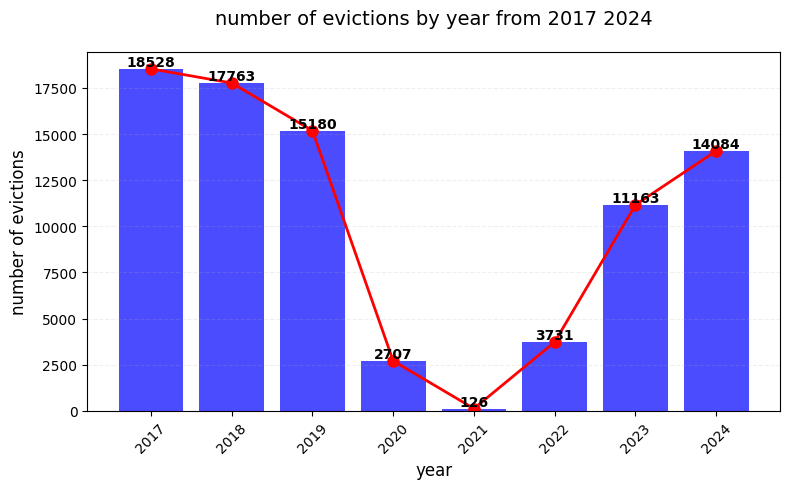

In [122]:
# count evictions by year
yearly_counts = evictions_df_cleaned.groupby(evictions_df_cleaned['executed_date'].dt.year).size()
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(yearly_counts.index, yearly_counts.values, color='blue', alpha=0.7)
ax.plot(yearly_counts.index, yearly_counts.values, color='red', marker='o', linewidth=2, markersize=8,)

# plot
plt.title('number of evictions by year from 2017 2024', fontsize=14, pad=20)
plt.xlabel('year', fontsize=12)
plt.ylabel('number of evictions', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.xticks(yearly_counts.index, rotation=45)

for i, v in enumerate(yearly_counts):
    ax.text(yearly_counts.index[i], v, str(v),
            ha='center', va='bottom',
            fontweight='bold')

plt.tight_layout()
plt.show()

In [123]:
print("Evictions per year:")
print(yearly_counts)

Evictions per year:
executed_date
2017    18528
2018    17763
2019    15180
2020     2707
2021      126
2022     3731
2023    11163
2024    14084
dtype: int64


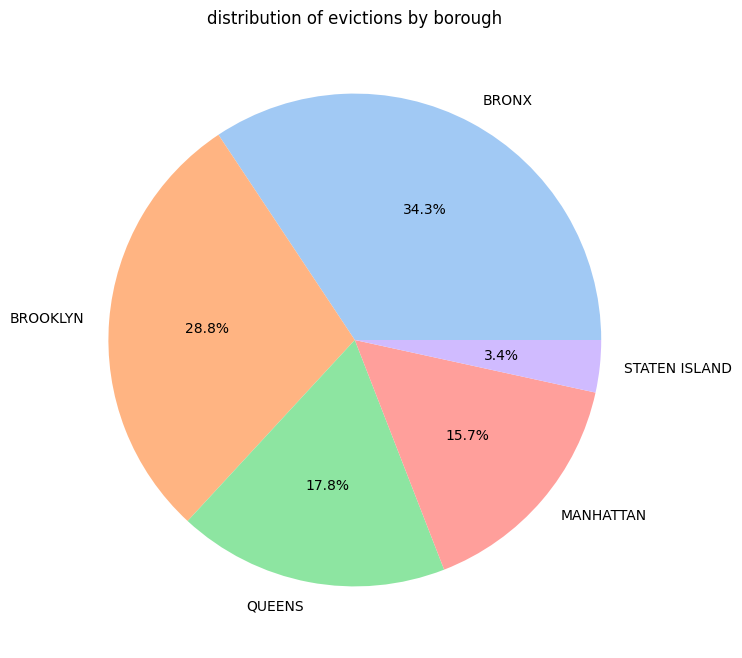

In [124]:
# borough-wise distribution
# Pie Chart
plt.figure(figsize=(10, 8))
evictions_df_cleaned['borough'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title('distribution of evictions by borough')
plt.ylabel('')
plt.show()

# borough trends over time
# stacked area chart
# misleading and not necessarily a good chart, as only the aggregate trend makes sense.
# plt.figure(figsize=(12, 16))
borough_time = evictions_df_cleaned.groupby([evictions_df_cleaned['executed_date'].dt.year, 'borough']).size().unstack()
# borough_time.plot(kind='area',
#                  stacked=True,
#                  color=pastel_colors)
# plt.title('Eviction trends by borough')
# plt.show()

In [132]:
# borough-wise distribution
borough_counts = evictions_df_cleaned['borough'].value_counts()
total_evictions = borough_counts.sum()
borough_summary = pd.DataFrame({
    'count': borough_counts,
    'percentage': (borough_counts / total_evictions * 100).round(1)
})
borough_summary.index = borough_summary.index.str.title()
borough_summary.index.name = 'Borough'
borough_summary = borough_summary.sort_values('count', ascending=False)

print("corough-wise distribution summary:")
display(borough_summary)

corough-wise distribution summary:


,count,percentage
Borough,,
Bronx,28596,34.3
Brooklyn,23981,28.8
Queens,14802,17.8
Manhattan,13052,15.7
Staten Island,2851,3.4


In [133]:
# borough trends by year
borough_time_copy = borough_time.copy()
borough_time_copy.columns = borough_time_copy.columns.str.title()
borough_time_copy.index.name = 'year'
borough_time_copy.columns.name = 'borough'
borough_time_copy

borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
year,,,,,
2017,6862,5220,2708,3261,477
2018,6359,5083,2533,3298,490
2019,5449,4365,2149,2740,477
2020,930,823,372,507,75
2021,13,50,21,18,24
2022,952,1395,599,552,233
2023,3830,3244,2098,1501,490
2024,4201,3801,2572,2925,585


In [134]:
# summary statistics
stats_data = []
for borough in borough_time.columns:
    stats_data.append({
        'borough': borough.title(),
        'total evictions': borough_time[borough].sum(),
        'average yearly evictions': borough_time[borough].mean().round(1),
        'peak year': borough_time[borough].idxmax(),
        'peak evictions': borough_time[borough].max()
    })

In [135]:
borough_stats_df = pd.DataFrame(stats_data)
borough_stats_df = borough_stats_df.set_index('borough')
borough_stats_df

,total evictions,average yearly evictions,peak year,peak evictions
borough,,,,
Bronx,28596,3574.5,2017,6862
Brooklyn,23981,2997.6,2017,5220
Manhattan,13052,1631.5,2017,2708
Queens,14802,1850.2,2018,3298
Staten Island,2851,356.4,2024,585


In [136]:
# yearly changes
yearly_changes = borough_time.pct_change() * 100
yearly_changes = yearly_changes.round(1)
yearly_changes.columns = yearly_changes.columns.str.title()
yearly_changes.index.name = 'year'
yearly_changes.columns.name = 'borough'
yearly_changes

borough,Bronx,Brooklyn,Manhattan,Queens,Staten Island
year,,,,,
2017,NaN,NaN,NaN,NaN,NaN
2018,-7.3,-2.6,-6.5,1.1,2.7
2019,-14.3,-14.1,-15.2,-16.9,-2.7
2020,-82.9,-81.1,-82.7,-81.5,-84.3
2021,-98.6,-93.9,-94.4,-96.4,-68.0
2022,7223.1,2690.0,2752.4,2966.7,870.8
2023,302.3,132.5,250.3,171.9,110.3
2024,9.7,17.2,22.6,94.9,19.4


#### monthly changes bar/line chart

In [137]:
evictions_df_cleaned['month_year'] = evictions_df_cleaned['executed_date'].dt.to_period('M')
monthly_trend = evictions_df_cleaned.groupby('month_year').size().reset_index()
monthly_trend.columns = ['month_year', 'count']

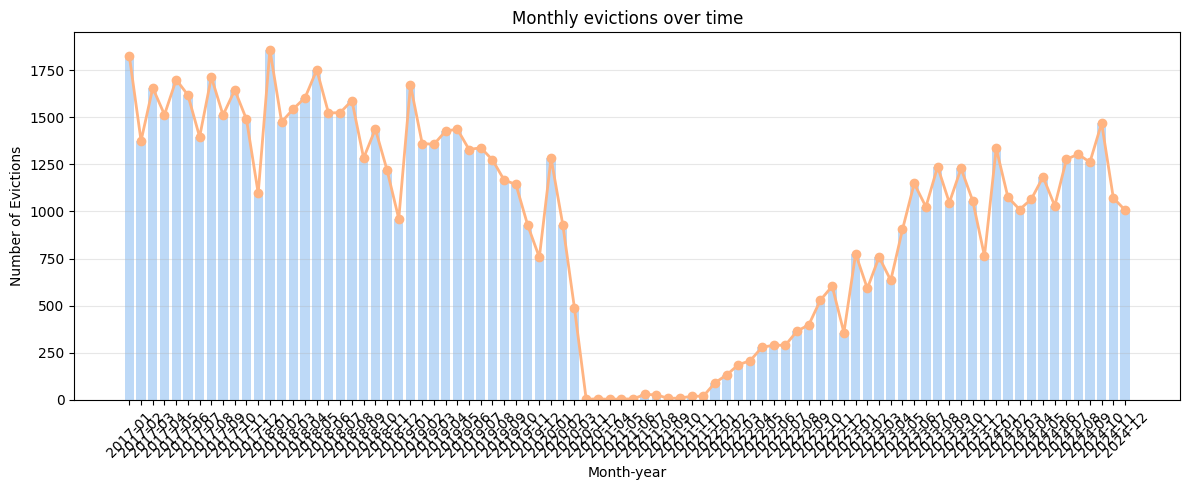

In [138]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(monthly_trend['month_year'].astype(str),
       monthly_trend['count'],
       color=sns.color_palette("pastel")[0],
       alpha=0.7)

ax.plot(monthly_trend['month_year'].astype(str),
        monthly_trend['count'],
        color=sns.color_palette("pastel")[1],
        marker='o',
        linewidth=2,
        markersize=6)

plt.title('Monthly evictions over time')
plt.xlabel('Month-year')
plt.ylabel('Number of Evictions')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [139]:
# monthly eviction counst
monthly_counts_df = monthly_trend[['month_year', 'count']].copy()
monthly_counts_df.columns = ['Month-Year', 'number of evictions']
monthly_counts_df = monthly_counts_df.set_index('Month-Year')
monthly_counts_df.head()

,number of evictions
Month-Year,
2017-01,1824
2017-02,1374
2017-03,1655
2017-04,1513
2017-05,1699


In [140]:
# create monthly stats summary
monthly_stats = pd.DataFrame([
    {'metric': 'total evictions', 'value': monthly_trend['count'].sum()},
    {'metric': 'average monthly evictions', 'value': round(monthly_trend['count'].mean(), 1)},
    {'metric': 'highest month',
     'value': f"{monthly_trend.loc[monthly_trend['count'].idxmax(), 'month_year']} ({monthly_trend['count'].max()} evictions)"},
    {'metric': 'lowest month',
     'value': f"{monthly_trend.loc[monthly_trend['count'].idxmin(), 'month_year']} ({monthly_trend['count'].min()} evictions)"}
])
monthly_stats = monthly_stats.set_index('metric')
print("monthly eviction statistics:")
display(monthly_stats)

monthly eviction statistics:


,value
metric,
total evictions,83282
average monthly evictions,968.4
highest month,2018-01 (1857 evictions)
lowest month,2020-11 (3 evictions)


In [148]:
# # monthly change value
# # largest monthly change
monthly_trend['change'] = monthly_trend['count'].diff()
monthly_trend['pct_change'] = monthly_trend['count'].pct_change() * 100

In [142]:
# largest_increases = monthly_trend.nlargest(10, 'change')[['month_year', 'change', 'pct_change']]
# largest_increases.columns = ['month_year', 'change', 'pct_change']
# largest_increases['pct_change'] = largest_increases['pct_change'].round(1)
# largest_increases = largest_increases.set_index('month_year')

In [143]:
# largest_decreases = monthly_trend.nsmallest(10, 'change')[['month_year', 'change', 'pct_change']]
# largest_decreases.columns = ['month_year', 'change', 'pct_change']
# largest_decreases['pct_change'] = largest_decreases['pct_change'].round(1)
# largest_decreases = largest_decreases.set_index('month_year')
# largest_decreases

In [149]:
# largest monthly increases
largest_increases = monthly_trend.nlargest(10, 'change')[['month_year', 'change', 'pct_change']]
largest_increases.columns = ['month_year', 'change', '% change']
largest_increases['% change'] = largest_increases['% change'].round(1)
largest_increases = largest_increases.set_index('month_year')

print("largest monthly increases:")
display(largest_increases)

largest monthly increases:


,change,% change
month_year,,
2018-01,761.0,69.4
2019-01,709.0,73.8
2024-01,572.0,75.0
2020-01,526.0,69.6
2023-01,418.0,117.1
2017-08,317.0,22.7
2017-03,281.0,20.5
2023-05,270.0,42.6
2024-07,248.0,24.1


In [150]:
# largest monthly decreases
largest_decreases = monthly_trend.nsmallest(10, 'change')[['month_year', 'change', 'pct_change']]
largest_decreases.columns = ['month_year', 'change', '% change']
largest_decreases['% change'] = largest_decreases['% change'].round(1)
largest_decreases = largest_decreases.set_index('month_year')

print("largest monthly decreases:")
display(largest_decreases)

largest monthly decreases:


,change,% change
month_year,,
2020-11,-483.0,-99.4
2017-02,-450.0,-24.7
2020-03,-444.0,-47.7
2024-11,-397.0,-27.0
2017-12,-392.0,-26.3
2018-02,-383.0,-20.6
2020-02,-352.0,-27.5
2019-02,-310.0,-18.6
2018-09,-305.0,-19.2


#### top 20 zipcodes bar chart

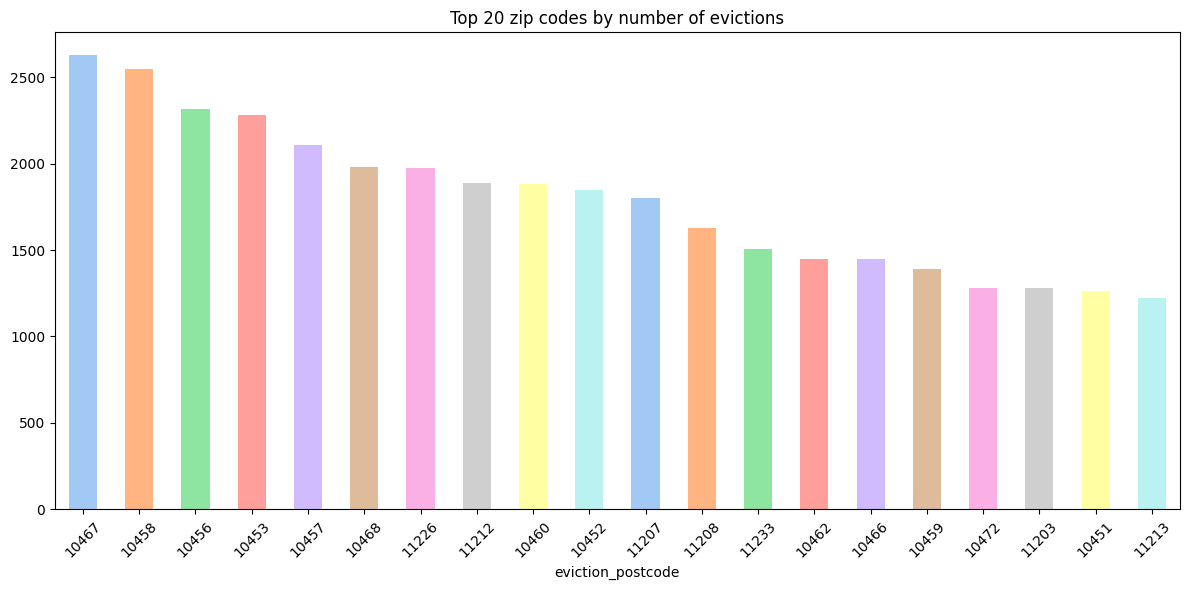

In [151]:
# top postal codes
# this visualization itself is less valuable than the community boards and concil districts (see below)
# because zipcodes are much harder to visualize for humans
# here just for reference
plt.figure(figsize=(12, 6))
evictions_df['eviction_postcode'].value_counts().head(20).plot(kind='bar',
                                                              color=pastel_colors)
plt.title('Top 20 zip codes by number of evictions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [152]:
# with %
zip_df = pd.DataFrame({'count': evictions_df_cleaned['eviction_postcode'].value_counts().head(20)})
zip_df['percentage'] = (zip_df['count'] / total_evictions * 100).round(2)

In [153]:
zip_df = zip_df.reset_index().rename(columns={'index': 'zip_code'})
print("top 20 zip codes by number of evictions:")
display(zip_df)

top 20 zip codes by number of evictions:


,eviction_postcode,count,percentage
0,10467,2455,2.95
1,10458,2410,2.89
2,10456,2180,2.62
3,10453,2162,2.60
4,10457,1970,2.37
5,11226,1885,2.26
6,10468,1876,2.25
7,11212,1798,2.16
8,10460,1784,2.14
9,10452,1731,2.08


#### finally, community boards

In [154]:
# community board mappings by borough
# source: https://www.nyc.gov/site/cau/community-boards/about-commmunity-boards.page

cb_names = {
    # Manhattan (1-12)
    1: "Financial District/Tribeca",
    2: "Greenwich Village/Little Italy/SoHo/NoHo",
    3: "Lower East Side/Chinatown",
    4: "Chelsea/Clinton/Hudson Yards",
    5: "Midtown",
    6: "Stuyvesant Town/Tudor City",
    7: "Upper West Side/Manhattan Valley",
    8: "Upper East Side",
    9: "Hamilton Heights/Morningside Heights/Manhattanville",
    10: "Central Harlem",
    11: "East Harlem",
    12: "Inwood/Washington Heights",

    # Bronx (201-212)
    201: "Mott Haven/Melrose/Port Morris",
    202: "Hunts Point/Longwood",
    203: "Morrisania/Crotona",
    204: "Highbridge/Concourse",
    205: "Morris Heights/Fordham South/Mount Hope",
    206: "Belmont/East Tremont/Bathgate",
    207: "Kingsbridge Heights/Bedford Park/Fordham/University Heights",
    208: "Riverdale/Kingsbridge/Marble Hill",
    209: "Parkchester/Unionport/Soundview",
    210: "Throgs Neck/Co-op City/Pelham Bay",
    211: "Morris Park/Bronxdale/Pelham Parkway",
    212: "Williamsbridge/Baychester",

    # Brooklyn (301-318)
    301: "Brooklyn Heights/DUMBO/Downtown Brooklyn",
    302: "Fort Greene/Brooklyn Navy Yard/Clinton Hill",
    303: "Bedford-Stuyvesant",
    304: "Bushwick",
    305: "East New York/Cypress Hills",
    306: "Red Hook/Park Slope",
    307: "Sunset Park/Windsor Terrace",
    308: "Crown Heights/Prospect Heights",
    309: "South Crown Heights/Prospect Lefferts Gardens",
    310: "Bay Ridge/Dyker Heights",
    311: "Bensonhurst/Bath Beach",
    312: "Borough Park/Ocean Parkway",
    313: "Coney Island/Brighton Beach",
    314: "Flatbush/Midwood",
    315: "Sheepshead Bay/Manhattan Beach/Gerritsen Beach",
    316: "Brownsville",
    317: "East Flatbush",
    318: "Flatlands/Canarsie",

    # Queens (401-414)
    401: "Astoria",
    402: "Sunnyside/Woodside",
    403: "Jackson Heights",
    404: "Elmhurst/Corona",
    405: "Ridgewood/Maspeth/Middle Village",
    406: "Rego Park/Forest Hills",
    407: "Flushing/Murray Hill/Whitestone",
    408: "Fresh Meadows/Briarwood",
    409: "Kew Gardens/Richmond Hill",
    410: "South Ozone Park/Howard Beach",
    411: "Bayside/Douglaston/Little Neck",
    412: "Jamaica/St. Albans/Hollis",
    413: "Queens Village/Rosedale",
    414: "Rockaway/Broad Channel",

    # Staten Island (501-503)
    501: "St. George/Stapleton",
    502: "South Beach/Willowbrook",
    503: "Tottenville/Great Kills"
}

In [155]:
# Council District mappings
# source: https://council.nyc.gov/districts/

cd_names = {
    # Manhattan
    1: "Lower Manhattan/Chinatown/Lower East Side",
    2: "East Village/Gramercy/Kips Bay",
    3: "Greenwich Village/Chelsea/Hell's Kitchen",
    4: "Upper East Side/East Midtown",
    5: "Upper East Side/Roosevelt Island/Sutton Place",
    6: "Upper West Side/Central Park",
    7: "Upper West Side/Manhattan Valley/Morningside Heights",
    8: "East Harlem/Mott Haven/Randall's Island",
    9: "Central Harlem/Morningside Heights/Upper West Side",
    10: "Central Harlem/East Harlem",

    # Brooklyn
    33: "Brooklyn Heights/Greenpoint/Williamsburg",
    34: "Bushwick/Ridgewood",
    35: "Fort Greene/Clinton Hill/Crown Heights",
    36: "Bedford-Stuyvesant/Crown Heights",
    37: "Bushwick/East New York/Cypress Hills",
    38: "Red Hook/Sunset Park/Windsor Terrace",
    39: "Cobble Hill/Park Slope/Prospect Heights",
    40: "Crown Heights/East Flatbush/Prospect Lefferts Gardens",
    41: "Bedford-Stuyvesant/Ocean Hill-Brownsville",
    42: "East New York/New Lots/Spring Creek",
    43: "Bay Ridge/Dyker Heights",
    44: "Bensonhurst/Borough Park",
    45: "Flatbush/Flatlands/Midwood",
    46: "Bergen Beach/Canarsie/Mill Basin",
    47: "Bensonhurst/Gravesend/Coney Island",
    48: "Brighton Beach/Manhattan Beach/Sheepshead Bay",

    # Bronx
    11: "Bedford Park/Morris Park/Riverdale/Wakefield",
    12: "Wakefield/Williamsbridge",
    13: "Allerton/City Island/Throgs Neck",
    14: "Morris Heights/University Heights/Fordham",
    15: "Bedford Park/Fordham/Mount Hope/Bathgate",
    16: "Claremont/Concourse/Morrisania",
    17: "Hunts Point/Longwood/Melrose",
    18: "Soundview/Parkchester",

    # Queens
    19: "College Point/Whitestone",
    20: "Downtown Flushing/Murray Hill",
    21: "Bayside/College Point/Fresh Meadows",
    22: "Astoria/East Elmhurst/Jackson Heights",
    23: "Fresh Meadows/Hollis/Queens Village",
    24: "Fresh Meadows/Jamaica Estates",
    25: "Elmhurst/Jackson Heights",
    26: "Long Island City/Sunnyside/Woodside",
    27: "Cambria Heights/Hollis/Jamaica",
    28: "Jamaica/Richmond Hill/Rochdale Village",
    29: "Forest Hills/Rego Park",
    30: "Glendale/Maspeth/Middle Village",
    31: "Arverne/Far Rockaway",
    32: "Belle Harbor/Breezy Point/Howard Beach",

    # Staten Island
    49: "North Shore",
    50: "Mid-Island",
    51: "South Shore"
}

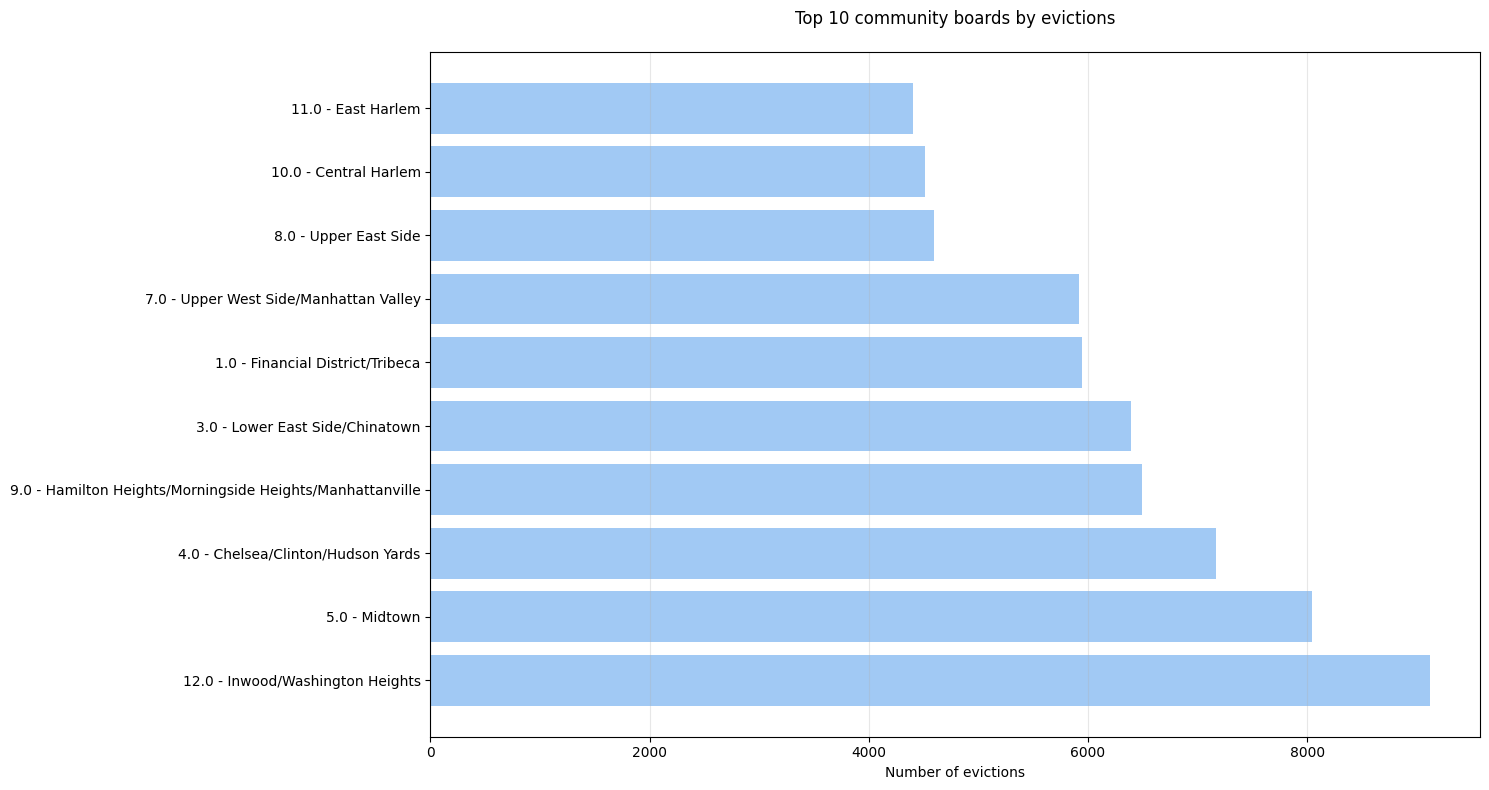

In [156]:
cb_counts = evictions_df_cleaned['community_board'].value_counts()
cb_df = pd.DataFrame({
    'district_number': cb_counts.index,
    'eviction_count': cb_counts.values
})
cb_df['district_name'] = cb_df['district_number'].map(cb_names)
cb_df = cb_df.sort_values('eviction_count', ascending=False)

plt.figure(figsize=(15, 8))
plt.barh(
    range(10),
    cb_df['eviction_count'].head(10),
    color=sns.color_palette("pastel")[0]
)

# labels for Community Boards
plt.yticks(
    range(10),
    [f"{num} - {name}" for num, name in
     zip(cb_df['district_number'].head(10),
         cb_df['district_name'].head(10))],
    fontsize=10
)

plt.title('Top 10 community boards by evictions', pad=20)
plt.xlabel('Number of evictions')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

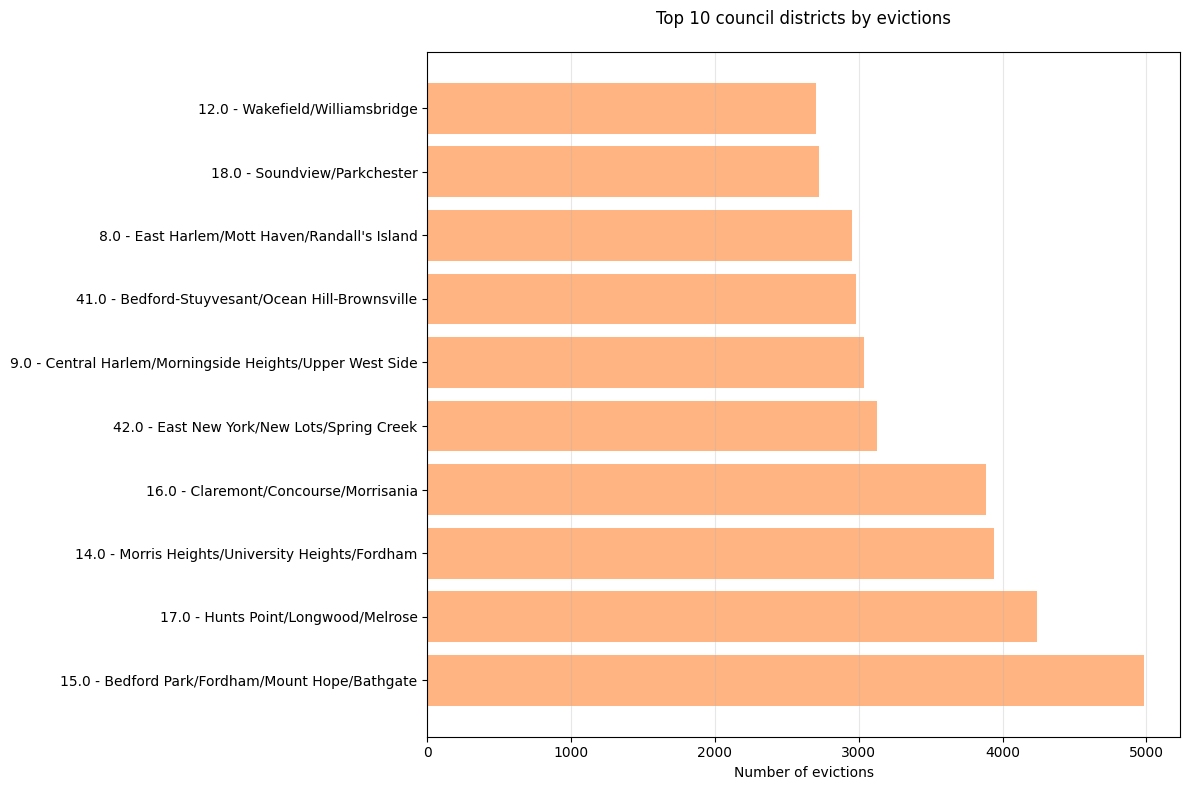

In [157]:
# Counsil district
cd_counts = evictions_df_cleaned['council_district'].value_counts()

cd_df = pd.DataFrame({
    'district_number': cd_counts.index,
    'eviction_count': cd_counts.values
})

cd_df['district_name'] = cd_df['district_number'].map(cd_names)
cd_df = cd_df.sort_values('eviction_count', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(
    range(10),
    cd_df['eviction_count'].head(10),
    color=sns.color_palette("pastel")[1]
)

# labels for council districts
plt.yticks(
    range(10),
    [f"{num} - {name}" for num, name in
     zip(cd_df['district_number'].head(10),
         cd_df['district_name'].head(10))],
    fontsize=10
)

plt.title('Top 10 council districts by evictions', pad=20)
plt.xlabel('Number of evictions')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [158]:
print("Top 10 community boards by evictions:")
cb_df[['district_number', 'district_name', 'eviction_count']].head(10)

Top 10 community boards by evictions:


,district_number,district_name,eviction_count
0,12.0,Inwood/Washington Heights,9121
1,5.0,Midtown,8047
2,4.0,Chelsea/Clinton/Hudson Yards,7172
3,9.0,Hamilton Heights/Morningside Heights/Manhattan...,6494
4,3.0,Lower East Side/Chinatown,6394
5,1.0,Financial District/Tribeca,5944
6,7.0,Upper West Side/Manhattan Valley,5922
7,8.0,Upper East Side,4597
8,10.0,Central Harlem,4509
9,11.0,East Harlem,4404


In [159]:
print("Top 10 council districts by evictions:")
cd_df[['district_number', 'district_name', 'eviction_count']].head(10)
# will need to come back get more

Top 10 council districts by evictions:


,district_number,district_name,eviction_count
0,15.0,Bedford Park/Fordham/Mount Hope/Bathgate,4984
1,17.0,Hunts Point/Longwood/Melrose,4236
2,14.0,Morris Heights/University Heights/Fordham,3942
3,16.0,Claremont/Concourse/Morrisania,3882
4,42.0,East New York/New Lots/Spring Creek,3128
5,9.0,Central Harlem/Morningside Heights/Upper West ...,3033
6,41.0,Bedford-Stuyvesant/Ocean Hill-Brownsville,2977
7,8.0,East Harlem/Mott Haven/Randall's Island,2953
8,18.0,Soundview/Parkchester,2722
9,12.0,Wakefield/Williamsbridge,2702


#### community boards are the governining entities of neighborhoods and the council districts serve similar purpose.

#### neighborhood trends

In [160]:
evictions_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83282 entries, 7797 to 21704
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   primary_key                83282 non-null  object        
 1   court_index_number         83282 non-null  object        
 2   docket_number              83282 non-null  object        
 3   eviction_address           83282 non-null  object        
 4   eviction_apartment_number  83282 non-null  object        
 5   executed_date              83282 non-null  datetime64[ns]
 6   borough                    83282 non-null  object        
 7   eviction_postcode          83282 non-null  int64         
 8   ejectment                  83282 non-null  object        
 9   eviction/legal_possession  83282 non-null  object        
 10  latitude                   83282 non-null  float64       
 11  longitude                  83282 non-null  float64       
 12  commun

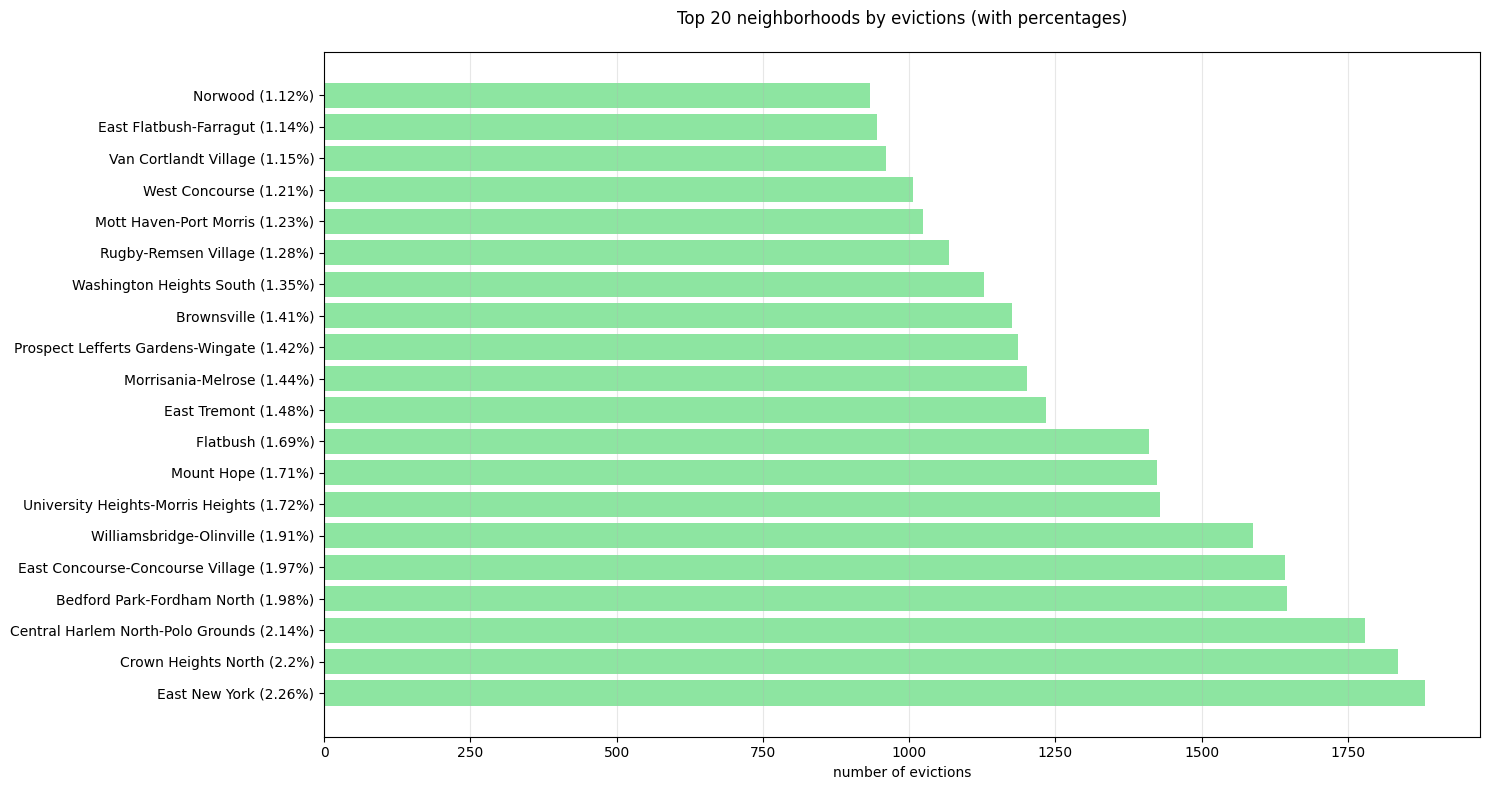

In [161]:
# nta %
nta_counts = evictions_df_cleaned['nta'].value_counts()
total_evictions = nta_counts.sum()
nta_analysis = pd.DataFrame({
    'eviction_count': nta_counts,
    'percentage': (nta_counts / total_evictions * 100).round(2)
})

nta_analysis = nta_analysis.sort_values('eviction_count', ascending=False)

plt.figure(figsize=(15, 8))
bars = plt.barh(
    range(20),
    nta_analysis['eviction_count'].head(20),
    color=sns.color_palette("pastel")[2]
)

plt.yticks(
    range(20),
    [f"{name} ({pct}%)" for name, pct in
     zip(nta_analysis.head(20).index,
         nta_analysis['percentage'].head(20))],
    fontsize=10
)

plt.title('Top 20 neighborhoods by evictions (with percentages)', pad=20)
plt.xlabel('number of evictions')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [162]:
print("Top 20 neighborhoods by evictions:")
nta_analysis.head(20)

Top 20 neighborhoods by evictions:


,eviction_count,percentage
nta,,
East New York,1882,2.26
Crown Heights North,1836,2.20
Central Harlem North-Polo Grounds,1779,2.14
Bedford Park-Fordham North,1647,1.98
East Concourse-Concourse Village,1642,1.97
Williamsbridge-Olinville,1588,1.91
University Heights-Morris Heights,1429,1.72
Mount Hope,1424,1.71
Flatbush,1411,1.69


In [163]:
evictions_df_cleaned.info()
# no nan, no duplicates

<class 'pandas.core.frame.DataFrame'>
Index: 83282 entries, 7797 to 21704
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   primary_key                83282 non-null  object        
 1   court_index_number         83282 non-null  object        
 2   docket_number              83282 non-null  object        
 3   eviction_address           83282 non-null  object        
 4   eviction_apartment_number  83282 non-null  object        
 5   executed_date              83282 non-null  datetime64[ns]
 6   borough                    83282 non-null  object        
 7   eviction_postcode          83282 non-null  int64         
 8   ejectment                  83282 non-null  object        
 9   eviction/legal_possession  83282 non-null  object        
 10  latitude                   83282 non-null  float64       
 11  longitude                  83282 non-null  float64       
 12  commun

In [164]:
# save cleaned evictions data to my drive
evictions_df_cleaned.to_csv('/content/drive/My Drive/X999/evictions_df_cleaned.csv', index=False)

In [165]:
evictions_df_cleaned.isna().sum()

,0
primary_key,0
court_index_number,0
docket_number,0
eviction_address,0
eviction_apartment_number,0
executed_date,0
borough,0
eviction_postcode,0
ejectment,0
eviction/legal_possession,0
